This notebook contains only CNN+MLP and Transfer learning using EfficientNetB0. The remaining two models that are used in transfer learning are implemented in another notebook named Koti_Sachin_project_part2.ipynb.

In [1]:
import pandas as pd
import random
import tensorflow as tf
from PIL import Image
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

## (a) Dataset

here, I have stored the data.zip file in my google drive and unzipped it directly here on the colab with the name **project_data** since the data file was pretty huge.

In [2]:
!unzip -d project_data /content/drive/MyDrive/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_6914_7213_4186_4485.json  
  inflating: project_data/__MACOSX

##(b) Data Exploration and Pre-processing

In [3]:
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./project_data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]


In [4]:
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)


In [5]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # img = tf.image.random_brightness(img, max_delta=0.2)
        # img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        # img = tf.image.rot90(img, k=1)

        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label


    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [6]:
len(tf_data_train), len(tf_data_val), len(tf_data_test)

(29679, 11286, 12823)

In [7]:
len(tf_dataset_train), len(tf_dataset_val), len(tf_dataset_test)

(928, 353, 401)

## Training CNN + MLP

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

Epoch 1/20
928/928 [==============================] - 342s 351ms/step - loss: 34.3307 - accuracy: 0.5105 - val_loss: 29.4250 - val_accuracy: 0.7374
Epoch 2/20
928/928 [==============================] - 313s 338ms/step - loss: 26.2975 - accuracy: 0.5195 - val_loss: 23.9067 - val_accuracy: 0.6752
Epoch 3/20
928/928 [==============================] - 311s 335ms/step - loss: 21.0308 - accuracy: 0.5208 - val_loss: 21.5472 - val_accuracy: 0.6680
Epoch 4/20
928/928 [==============================] - 311s 335ms/step - loss: 17.0848 - accuracy: 0.5200 - val_loss: 15.3998 - val_accuracy: 0.3511
Epoch 5/20
928/928 [==============================] - 312s 336ms/step - loss: 14.0376 - accuracy: 0.5313 - val_loss: 12.9041 - val_accuracy: 0.4591
Epoch 6/20
928/928 [==============================] - 312s 336ms/step - loss: 12.0415 - accuracy: 0.5214 - val_loss: 12.3659 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 312s 336ms/step - loss: 10.7066 - accuracy: 0.5175 - val_l

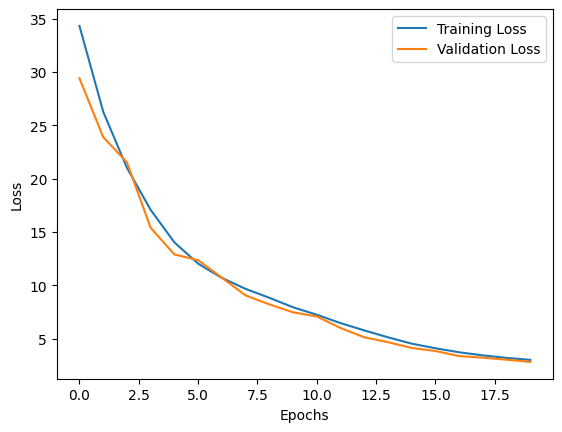

In [ ]:
model = Sequential()

model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness([-0.8,0.8]),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])


test_loss, test_acc = model.evaluate(tf_dataset_test)

y_true_list = []
y_pred_list = []

for batch in tf_dataset_test:
    X_batch, y_true_batch = batch

    y_pred_batch = model.predict(X_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    y_true_list.extend(y_true_batch.numpy())
    y_pred_list.extend(y_pred_classes_batch)

y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

classification_rep = classification_report(y_true, y_pred)
print(classification_rep)

# Plot Training and Validation Errors
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## (d) Transfer Learning

### EfficientNetB0

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
928/928 [==============================] - 442s 444ms/step - loss: 1.9105 - accuracy: 0.5552 - val_loss: 0.9649 - val_accuracy: 0.3218
Epoch 2/10
928/928 [==============================] - 356s 383ms/step - loss: 0.6855 - accuracy: 0.5879 - val_loss: 0.8363 - val_accuracy: 0.3218
Epoch 3/10
928/928 [==============================] - 353s 380ms/step - loss: 0.6850 - accuracy: 0.5877 - val_loss: 0.6730 - val_accuracy: 0.6782
Epoch 4/10
928/928 [==============================] - 353s 380ms/step - loss: 0.6855 - accuracy: 0.5876 - val_loss: 0.7684 - val_accuracy: 0.3218
Epoch 5/10
928/928 [==============================] - 354s 382ms/step - loss: 0.6830 - accuracy: 0.5878 - val_loss: 0.7977 - val_accuracy: 0.3218
Epoch 6/10
928/928 [==============================] - 355s 383ms/step - loss: 0.6833 - accuracy: 0.5878 - val_loss: 0.7392 - val_accuracy: 0.3218
Epoch 7/10
928/928 [==============================] - 356s 

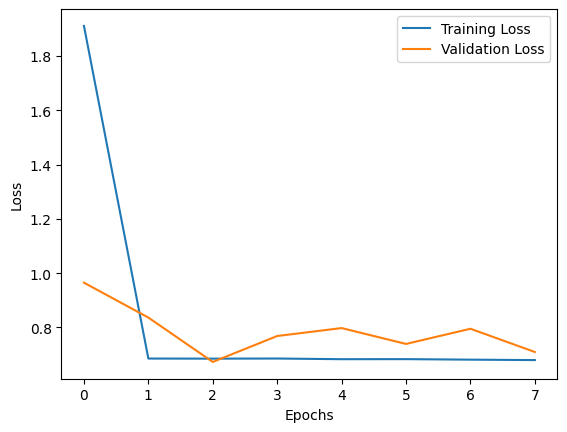

In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299,299,3))
for layer in base_model.layers[:-1]:
  layer.trainable = False

model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness([-0.8,0.8]),
    layers.RandomContrast(0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(tf_dataset_test)

y_true_list = []
y_pred_list = []

for batch in tf_dataset_test:
    X_batch, y_true_batch = batch

    y_pred_batch = model.predict(X_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    y_true_list.extend(y_true_batch.numpy())  # Assuming y_true_batch is a TensorFlow tensor
    y_pred_list.extend(y_pred_classes_batch)

# Convert lists to NumPy arrays for further analysis
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Calculate classification metrics
classification_rep = classification_report(y_true, y_pred, zero_division=1)
print(classification_rep)

# Plot Training and Validation Errors
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
